# CSE3001 Assignment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory for the assignment
import os
SKELETON_DIR = '/content/drive/MyDrive/Uni/CSE3001/Assignment'
os.chdir(SKELETON_DIR)
! mkdir -p "$SKELETON_DIR/saved_models"
! mkdir -p "$SKELETON_DIR/logs"

# Set up auto-reloading modules from the working directory
%load_ext autoreload
%autoreload 2

# Install extra dependencies
!pip install -q wandb==0.15.0
!pip install -q torchmetrics==0.11.3

# Set the default figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 kB 6.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%shell
DATA_URL='https://latrobeuni-my.sharepoint.com/:u:/g/personal/zhe_ltu_edu_au/Edn2-_XuX2pGptMfH6eVLIoB16_ofpRlZnCf6rwP47EkBQ?e=ogAWGM&download=1'

DATA_ZIP="/content/drive/MyDrive/Uni/CSE3001/Assignment/data.zip"

# pushd /content/drive/MyDrive/Uni/CSE3001/Assignment
# wget -O data.zip $DATA_URL
# unzip -q data.zip
# popd

if [ -f "$DATA_ZIP" ]; then
  echo "data.zip already exists. Skipping the download."
else
  # If it doesn't exist, download it
  pushd /content/drive/MyDrive/Uni/CSE3001/Assignment
  wget -O data.zip $DATA_URL
  unzip -q data.zip
  popd
fi


data.zip already exists. Skipping the download.


## Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

import datasets
import models
import train

torch.manual_seed(42)


# Task 1 - Image Classification


In this first task, I will create a deep learning model to classify images of skin lesions into one of seven classes:

1.   "MEL" = Melanoma
2.   "NV" = Melanocytic nevus
3.   "BCC" = Basal cell carcinoma
4.   "AKIEC" = Actinic keratosis
5.   "BKL" = Benign keratosis
6.   "DF" = Dermatofibroma
7.   "VASC" = Vascular lesion

The data for this task is a subset of: https://challenge2018.isic-archive.com/task3/

The data for this task is inside the `/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img` folder. It contains ~3,800 images named like `ISIC_000000.jpg` and the following label files:

*   `/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv`
*   `/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val.csv`
*   `/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train_small.csv`
*   `/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val_small.csv`

The `small` versions are the first 200 lines of each partition and are included for debugging purposes. To save time, ensure your code runs on the `small` versions first.

**NOTE**: To explore the labels, you can click the above hyperlinks to open the relevant csv file.

## Task 1a. Explore the training set

**INSTRUCTIONS**: Check for data issues, as we have done in the labs. Check the class distribution and at least 1 other potential data issue. Hint: Look in `explore.py` for a function that can plot the class distribution.


In [5]:
import pandas as pd

IMG_CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

train_df = pd.read_csv('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val.csv')
train_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_df['image'][300]

'ISIC_0024606'

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   3004 non-null   object 
 1   MEL     3004 non-null   float64
 2   NV      3004 non-null   float64
 3   BCC     3004 non-null   float64
 4   AKIEC   3004 non-null   float64
 5   BKL     3004 non-null   float64
 6   DF      3004 non-null   float64
 7   VASC    3004 non-null   float64
dtypes: float64(7), object(1)
memory usage: 187.9+ KB


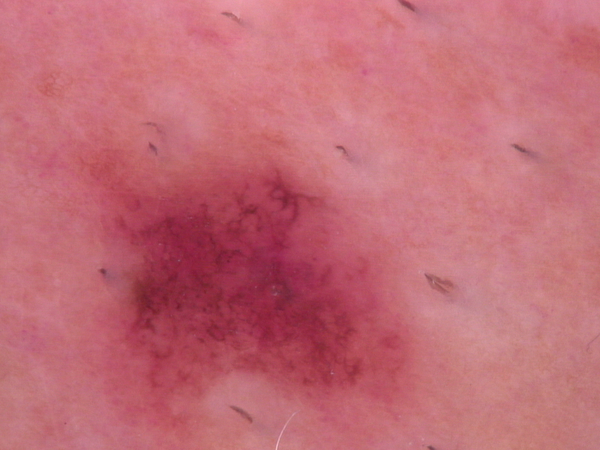

In [8]:
from PIL import Image
# Change the filename to view other examples from the dataset
display(Image.open('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/ISIC_0024309.jpg'))

In [9]:
import explore

# TODO - Check for data issues
# Hint: You can convert from one-hot to integers with argmax
#       This way you can convert 1, 0, 0, 0, 0, 0, 0  to class 0
#                                0, 1, 0, 0, 0, 0, 0  to class 1
#                                0, 0, 1, 0, 0, 0, 0  to class 2
# so it should be something like the following:
# train_labels = train_df.values[....].argmax(....)
# val_labels = val_df.values[....].argmax(....)
#     - you need to fill in the ... parts with the correct values.
# You should then print output the contents of train_labels to see if
# it matches the contents of train.csv
#
# Next you can plot the class distributions like the following:
# explore.plot_label_distribution(....)
#    - do the above for both the train and val labels.
#
# Following this look for other potential problems with the data
#   You can look at lab 2a to see what was checked there.
#   You may also think of any other potential problems with the data.


In [10]:
train_labels = train_df.values[:, 1:].argmax(axis=1)
val_labels = val_df.values[:, 1:].argmax(axis=1)

[267, 2052, 151, 114, 339, 36, 45]


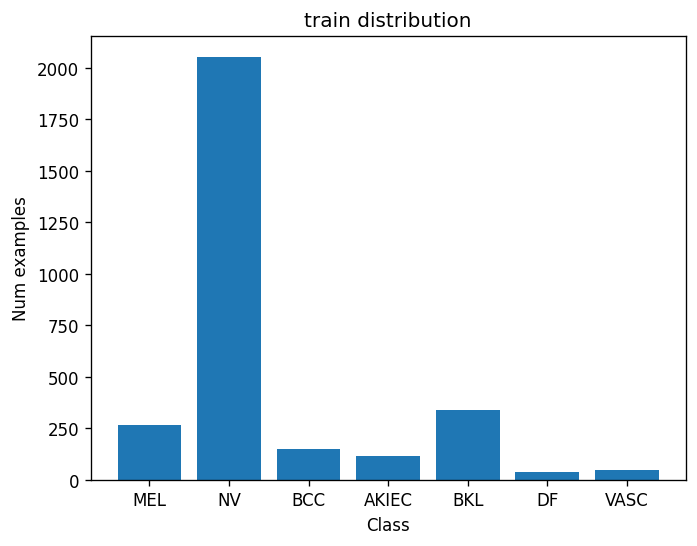

In [11]:
explore.plot_label_distribution(train_labels, 'train', ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])

[32, 281, 21, 18, 38, 5, 5]


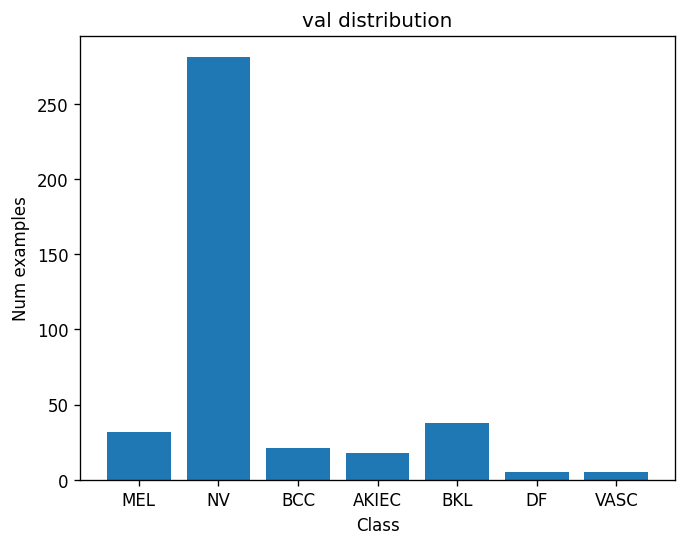

In [12]:
explore.plot_label_distribution(val_labels, 'val', ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])

In [13]:
# Check for Missing Values
print('TRAIN\n', train_df.isna().sum())
print('VAL\n', val_df.isna().sum())

TRAIN
 image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64
VAL
 image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64


## Task 1b. Implement Training loop

**INSTRUCTIONS**:

*   Implement LesionDataset in `datasets.py`. Use the cell below to test your implementation.
*   Implement the incomplete functions in `train.py` marked as "Task 1b"
*   Go to the [Model Training Cell](#task-1-model-training) at the end of Task 1 and fill in the required code for "Task 1b".


In [14]:
import datasets

ds = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv')
for i in range(10):
  input, label = ds[i]
  print(input.shape)
  print(label)

torch.Size([3, 450, 600])
1
torch.Size([3, 450, 600])
1
torch.Size([3, 450, 600])
1
torch.Size([3, 450, 600])
1
torch.Size([3, 450, 600])
0
torch.Size([3, 450, 600])
1
torch.Size([3, 450, 600])
4
torch.Size([3, 450, 600])
0
torch.Size([3, 450, 600])
1
torch.Size([3, 450, 600])
0


In [15]:
ds.get_all_class_names()

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

## Task 1c. Implement a baseline convolutional neural network


**INSTRUCTIONS**:

*   Implement a `SimpleBNConv` in `models.py` with:
    *   5 `nn.Conv2d` layers, with 8, 16, 32, 64, 128 output channels respectively, with the following between each convolution layer:
        *   `nn.ReLU()` for the activation function, and
        *   `nn.BatchNorm2d`, and
        *   finally a `nn.MaxPool2d` to downsample by a factor of 2.
*   Use a normalised confusion matrix on the model's validation predictions in `train.py`.
*  Go to the [Model Training Cell](#task-1-model-training) at the end of Task 1 and fill in the required code to train the model.

Training should take about 1 minute/epoch. Validation accuracy should be 60-70%, but UAR should be around 20-40%.


## Task 1d. Account for data issues

**INSTRUCTIONS**: Account for the data issues in Task 1a and retrain your model.

The data issue we faced with is Imbalanced Dataset. To solving this problem, I use Weighted Loss Function, which I add weight to each class in dataset.

In [16]:
# data_labels = pd.Series(np.concatenate(train_labels, val_labels))
data_labels = pd.Series(np.concatenate((train_labels, val_labels), axis=0))
class_counts = data_labels.value_counts()
weights = [class_counts[i] for i in range(len(class_counts))]
weights

[299, 2333, 172, 132, 377, 41, 50]

In [17]:
# Normalise weight using np.sqrl
normalised_weights = np.sqrt(weights)

In [18]:
class_weights = 1 / torch.Tensor(normalised_weights)
# class_weights = 1 / torch.Tensor(weights)
class_weights

tensor([0.0578, 0.0207, 0.0762, 0.0870, 0.0515, 0.1562, 0.1414])

## Task 1e. Data Augmentation


**INSTRUCTIONS**:

*   Add an `augment` flag to LesionDataset which specifies whether any augmentation is done to the images. Ensure it is set to `True` *only* for the training dataset.
*   Use random horizontal flips
*   Use at least 2 other different non-deterministic augmentations


## Task 1f. Chase improved performance



**INSTRUCTIONS**:
*   Create a model from a pre-trained model from the torchvision model zoo. We recommend Resnet18, but you may use any model you like. You may freeze the weights of all layers except the last, or fine-tune all the weights. https://drive.google.com/file/d/12Bq-00qRNTBxzGZ9X_iqWndluB5hmuG1/view?usp=share_link
*   Create your own models, modifying the model architecture, try different losses, learning rates. Change anything you like except the evaluation metrics in search of a better model.

Train at least 10 different models, each with a different combination.

<a name="task-1-model-training"></a>
## Model Training Cell

Based on what you have implemented in the above sections, you can try to complete the whole training process here.


### Testing

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▂▃▅▅▅▆▆▇█
Accuracy_val,▃▅▁▇▄█▆▇█▇
Loss_train,█▆▅▄▃▂▂▂▁▁
Loss_val,█▆▄▃▃▂▂▁▁▁
UAR_train,▁▂▃▄▅▅▆▆▇█
UAR_val,▁▄▄▄▆▆▇▇██
Accuracy_train,0.73069
Accuracy_val,0.7075
Loss_train,0.99628
Loss_val,1.06646
UAR_train,0.50301


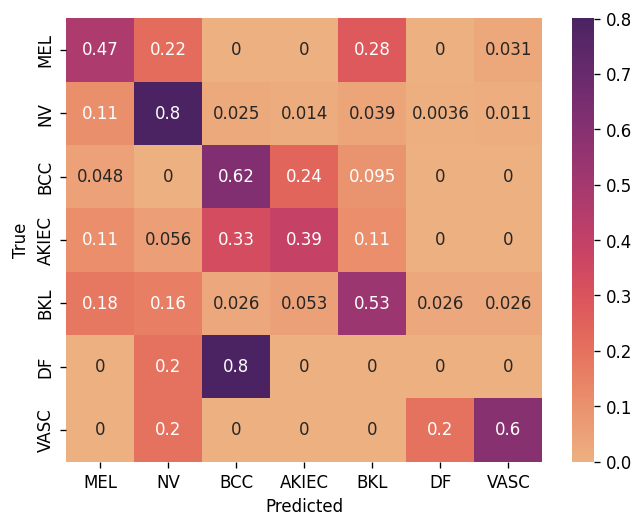

In [19]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
LR = 0.001

train_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv', True)
val_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val.csv',)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = models.SimpleBNConv()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())

train.train_model(model, train_loader, val_loader, optimizer, criterion,
                  IMG_CLASS_NAMES, NUM_EPOCHS, project_name="Final Experiments",
                  ident_str= "SimpleBNConv")



### Custom Model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.7MB/s]
wandb: Currently logged in as: nminhquang380 (duc-minh-quang-nguyen). Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▄▅▅▅▇▇▇██
Accuracy_val,█▆▁▅▄▇▇▇▆▅
Loss_train,█▅▄▃▃▂▂▂▁▁
Loss_val,▅▄█▄▃▁▁▁▄▄
UAR_train,▁▃▃▅▆▆▇▇██
UAR_val,▃▂▁▄▅▆█▇▇▇
Accuracy_train,0.70539
Accuracy_val,0.4975
Loss_train,0.99575
Loss_val,1.4249
UAR_train,0.49052


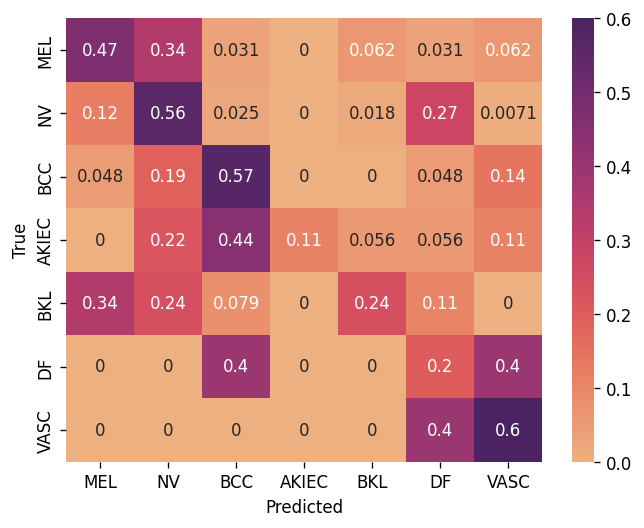

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁█▇▆▇█▇▇▇█
Accuracy_val,▁██▆▇█▇▇▇▃
Loss_train,▇█▇▇▄▄▄▃▂▁
Loss_val,█▆▇▅▄▄▃▁▁▄
UAR_train,▂▁▁▂▂▃▃▄▆█
UAR_val,▁▂▂▆▅▂▅██▅
Accuracy_train,0.67543
Accuracy_val,0.48
Loss_train,1.31747
Loss_val,1.48567
UAR_train,0.3441


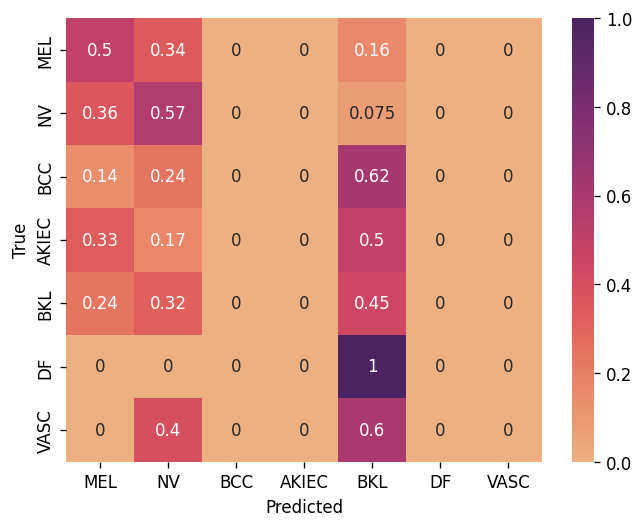

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▅▅▆▆▆▇██▇
Accuracy_val,▅▆▂▃▃▆█▁▅▄
Loss_train,█▆▅▄▃▂▂▂▁▁
Loss_val,█▄▆▄▄▃▁▆▁▃
UAR_train,▁▄▅▆▇▇▇███
UAR_val,▁▃▄▅▇▇█▅█▆
Accuracy_train,0.68675
Accuracy_val,0.6125
Loss_train,0.97967
Loss_val,1.22236
UAR_train,0.5036


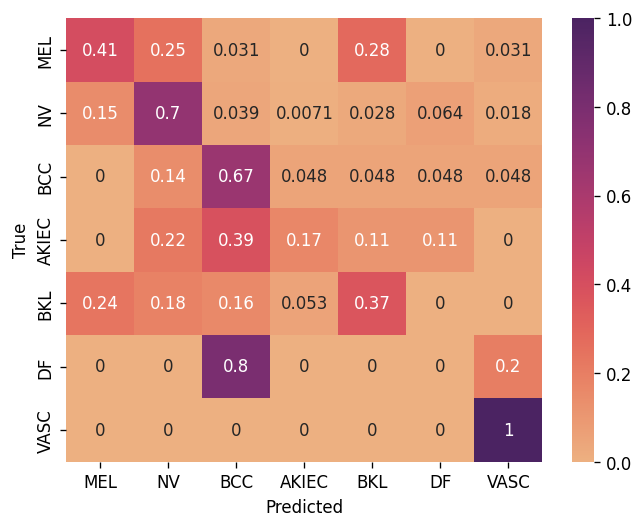

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▁▄▃▄▆▇▇██
Accuracy_val,▁▃▃▂▇▅▇█▇█
Loss_train,█▃▃▂▂▂▂▂▂▁
Loss_val,█▅▄▃▃▂▂▃▁▁
UAR_train,▁▃▃▄▆▆▅▅▅█
UAR_val,▅▅▇▅▅▆▅▁▆█
Accuracy_train,0.65413
Accuracy_val,0.68
Loss_train,1.22033
Loss_val,1.23938
UAR_train,0.36039


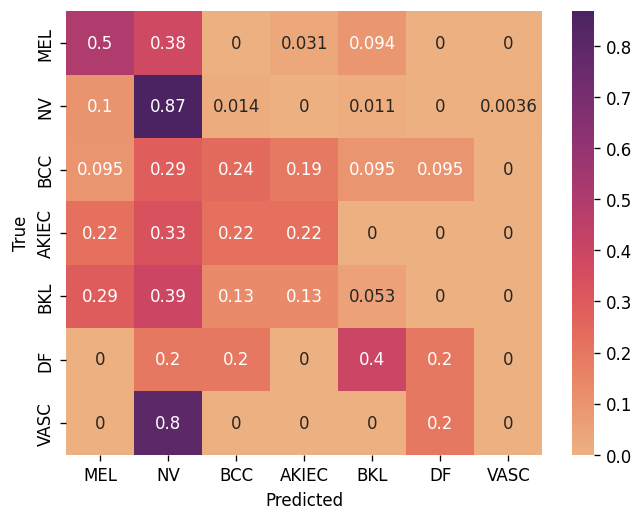

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
LR = 0.001

# Create datasets/loaders
# TODO Task 1b - Create the data loaders from LesionDatasets
# TODO Task 1d - Account for data issues, if applicable
train_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv', True)
val_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val.csv')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate model, optimizer and criterion
# TODO Task 1c - Make an instance of your model
# TODO Task 1d - Account for data issues, if applicable
resnet18 = models.construct_resnet18()
model_list = [models.SimpleBNConv(),
          models.DropoutConvNet(), # 2 Dropout layer 0.25
          models.DropoutBatchNormNet(), # 1 Dropout layer 0,4, Batch Norm
          models.DeepConvNet(), # No batch norm, No Max Pooling, Stride = 2
          models.DeepConvBatchNormNet(), # NO Max Pooling, Stride = 2
        ]

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())

# Train model
# TODO Task 1c: Set ident_str to a string that identifies this particular
#               training run. Note this line in the training code
#                     exp_name = f"{model.__class__.__name__}_{ident_str}"
#               So it means the the model class name is already included in the
#               exp_name string. You can consider adding other information
#               particular to this training run, e.g. learning rate (lr) used,
#               augmentation (aug) used or not, etc.

# train.train_model(model, train_loader, val_loader, optimizer, criterion,
#                   IMG_CLASS_NAMES, NUM_EPOCHS, project_name="CSE3001 Assignment Task 1",
#                   ident_str= "SimpleBNConv 64 5 001 Adam weight F-dataset")

for model in model_list:

  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
  ident_str = str(BATCH_SIZE) + " " + str(NUM_EPOCHS) + " " + str(LR) + " " + optimizer.__class__.__name__

  train.train_model(model, train_loader, val_loader, optimizer, criterion,
                  IMG_CLASS_NAMES, NUM_EPOCHS, project_name="Final Experiments",
                  ident_str= ident_str)

### SkipBlock Model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁█▇▇██▆█▆▆
Accuracy_val,█▅▁███████
Loss_train,█▁▁▁▁▁▁▁▁▁
Loss_val,▆▃▁█▇▄▆▆▄▄
UAR_train,▅▁▆▃▁▁▃▁▆█
UAR_val,▁▁█▁▁▁▁▁▁▁
Accuracy_train,0.64348
Accuracy_val,0.7025
Loss_train,1.55822
Loss_val,1.60122
UAR_train,0.17237


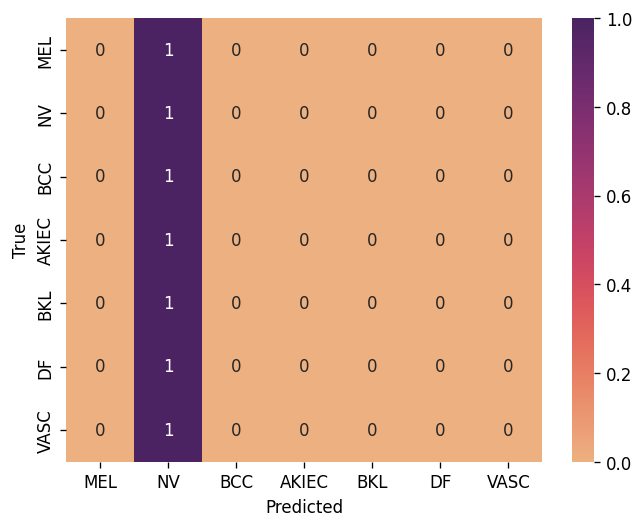

wandb: Currently logged in as: nminhquang380 (duc-minh-quang-nguyen). Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▄▆▆▇▇▇███
Accuracy_val,█▃▄▄▁▅▂▁▅▅
Loss_train,█▂▂▂▂▂▁▁▁▁
Loss_val,▄▇▄▃▇▁█▆▃▅
UAR_train,▁▂▄▄▅▅▆▇▇█
UAR_val,▁▄▃▅▄▇▂▃█▅
Accuracy_train,0.6751
Accuracy_val,0.5575
Loss_train,1.06748
Loss_val,1.40391
UAR_train,0.44542


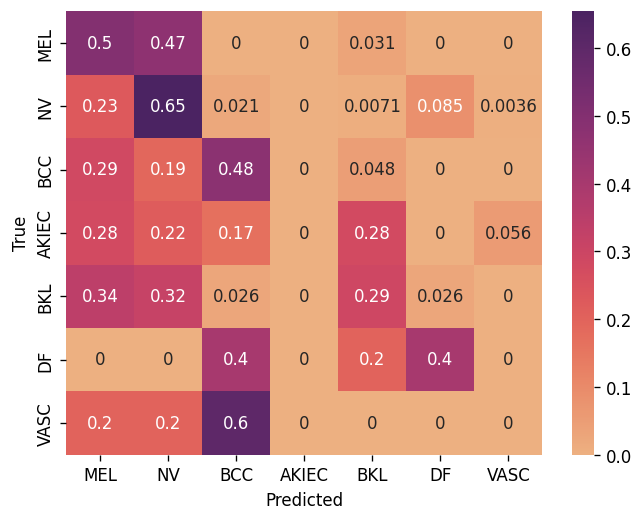

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▆▆▆▆▇█▇▆█
Accuracy_val,▇▃▇▂▁▆▆▅█▅
Loss_train,█▃▂▂▂▂▂▁▁▁
Loss_val,█▄▃▅▆▂▁▂▁▂
UAR_train,▁▁▃▄▄▅▆▇▇█
UAR_val,▁▆▆▃▅▅█▇█▄
Accuracy_train,0.68009
Accuracy_val,0.57
Loss_train,1.09749
Loss_val,1.22186
UAR_train,0.42841


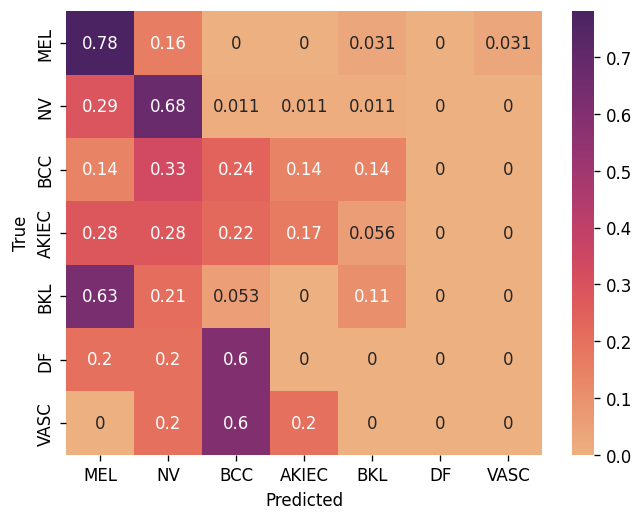

In [19]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
LR = 0.001

train_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv', True)
val_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val.csv')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

resnet18 = models.construct_resnet18()
model_list = [models.SkipNet(), # 3 SkipBlock 8 16 32
              models.SkipBNNet(), # Add Batch Norm Layers
              models.DropOutSkipBNNet(), # Add Dropout Layer, Batch Norm
        ]
# model = models.DropOutSkipBNNet()

for model in model_list:
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())

  ident_str = str(BATCH_SIZE) + " " + str(NUM_EPOCHS) + " " + str(LR) + " " + optimizer.__class__.__name__
  train.train_model(model, train_loader, val_loader, optimizer, criterion,
                    IMG_CLASS_NAMES, NUM_EPOCHS, project_name="Final Experiments",
                    ident_str= ident_str)

### Pretrained Model


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.4MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 100MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 124MB/s]


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▄▆▆▇▇▇███
Accuracy_val,▆█▇▆▂▃▁██▇
Loss_train,█▅▄▃▂▂▂▁▁▁
Loss_val,█▅▄▃▃▂▂▁▁▁
UAR_train,▁▃▅▆▆▇▇███
UAR_val,▁▅▅▇▇▇████
Accuracy_train,0.76065
Accuracy_val,0.7
Loss_train,0.91479
Loss_val,0.9722
UAR_train,0.54447


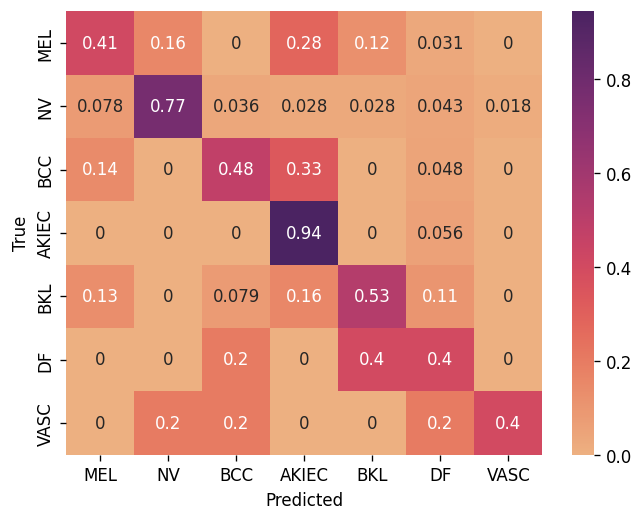

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▃▄▆▆▆▆▇██
Accuracy_val,▁▂▄▆▇▇▇███
Loss_train,█▅▄▃▃▂▂▂▁▁
Loss_val,█▆▄▃▃▂▂▂▁▁
UAR_train,▁▃▅▆▆▆▇▇██
UAR_val,▁▃▄▅▆▇▇▇██
Accuracy_train,0.81292
Accuracy_val,0.77
Loss_train,0.77663
Loss_val,0.89599
UAR_train,0.65771


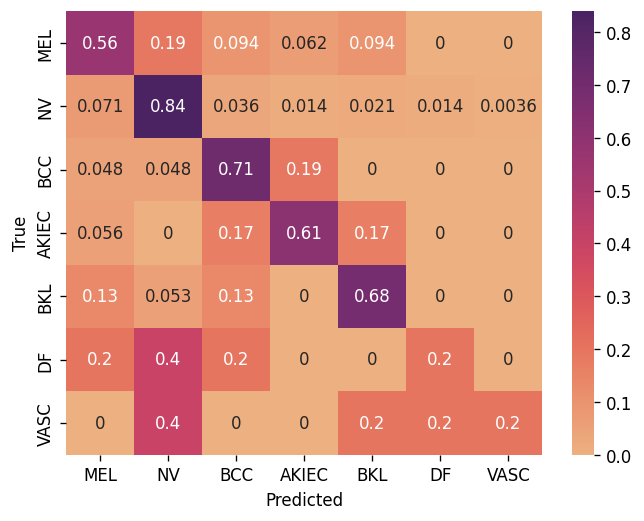

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▃▃▄▅▇▇▇▇█
Accuracy_val,▁▄▇▂▁██▇▃▁
Loss_train,█▅▄▃▃▂▂▁▁▁
Loss_val,█▅▃▃▃▂▁▁▁▂
UAR_train,▁▄▅▆▇█████
UAR_val,▁▅▄▆█▅▇█▇▇
Accuracy_train,0.78129
Accuracy_val,0.7075
Loss_train,0.75096
Loss_val,0.99946
UAR_train,0.66204


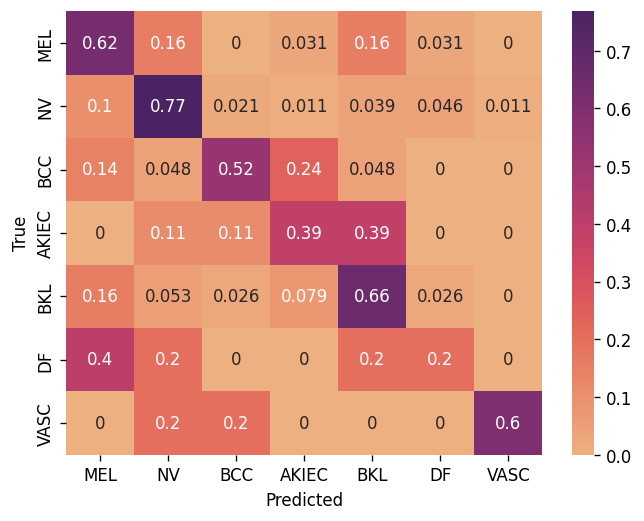

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy_train,▁▄▅▆▆▆▇▇▇█
Accuracy_val,▅▁▂▃▅███▇█
Loss_train,█▅▄▃▃▂▂▂▁▁
Loss_val,█▆▄▃▃▂▂▂▁▁
UAR_train,▁▃▅▆▆▆▇▇▇█
UAR_val,▁▃▄▅▆█▇███
Accuracy_train,0.78795
Accuracy_val,0.7675
Loss_train,0.81344
Loss_val,0.82871
UAR_train,0.6052


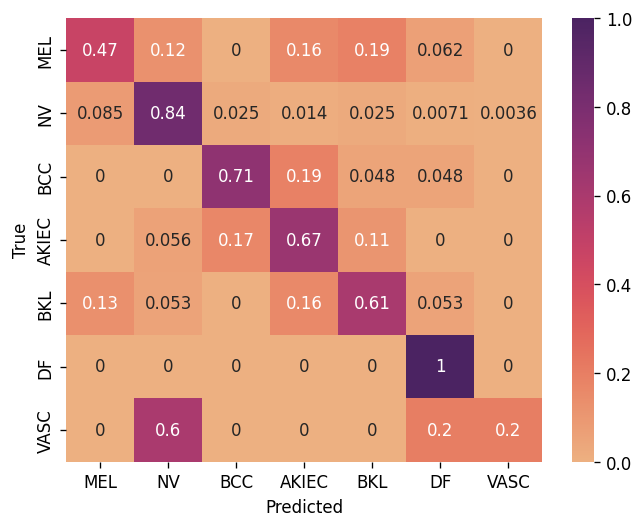

In [20]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
LR = 0.001

train_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/train.csv', True)
val_dataset = datasets.LesionDataset('/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img',
                            '/content/drive/MyDrive/Uni/CSE3001/Assignment/data/img/val.csv')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model_list = [models.construct_resnet18(),
              models.construct_resnet50_v2(),
              models.construct_efficientnet_v2_s(),
              models.construct_densenet_121(),
        ]
# model = models.DropOutSkipBNNet()

for model in model_list:
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())

  ident_str = str(BATCH_SIZE) + " " + str(NUM_EPOCHS) + " " + str(LR) + " " + optimizer.__class__.__name__
  train.train_model(model, train_loader, val_loader, optimizer, criterion,
                    IMG_CLASS_NAMES, NUM_EPOCHS, project_name="Final Experiments",
                    ident_str= ident_str)